# Predicting Sentiment on Social Media Data Using Supervised Approaches
[DM2583 Big Data in Media Technology Course](https://www.kth.se/student/kurser/kurs/DM2583?l=en),[KTH Royal Institute of Technology](https://www.kth.se), Spring 2019  

Authors: [Fadhil Mochammad](https://www.github.com/fadhilmch) (fadhilm@kth.se), [M. Irfan Handarbeni](https://www.github.com/handarbeni) (handa@kth.se), Mehrdad Darraji

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from time import time

### Import Dataset

Import the cleaned training and test data from the path '../data/'

In [2]:
df_train_data = pd.read_csv('../data/cleaned_train.csv')
df_test_data = pd.read_csv('../idata/cleaned_test.csv')

#df_train_data = pd.read_csv('../data/train_cleaned_reviews.csv')
#df_test_data = pd.read_csv('../data/test_cleaned_reviews.csv')

In [3]:
df_train_data.columns = ['tweet','target']
df_train_data = df_train_data.sample(frac = 0.177)
df_train_data.shape

(99762, 2)

In [4]:
df_test_data.columns = ['tweet','target']
df_test_data.shape


(1000000, 2)

### Split Training and Validation Data

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(df_train_data.tweet, df_train_data.target, test_size = 0.02, random_state = 1234)

print("training data has {0} entries. {1:.2f}% positive and {2:.2f}% negative".format(len(y_train), len(y_train[y_train==1])/len(y_train)*100, len(y_train[y_train==0])/len(y_train)*100))
print("validation data has {0} entries. {1:.2f}% positive and {2:.2f}% negative".format(len(y_validation), len(y_validation[y_validation==1])/len(y_validation)*100, len(y_validation[y_validation==0])/len(y_validation)*100))

training data has 97766 entries. 49.44% positive and 50.56% negative
validation data has 1996 entries. 48.60% positive and 51.40% negative


In [7]:
len(y_train[y_train==1])/len(y_train)

0.4943743223615572

### Sentiment Pred with TextBlob

We experiment the sentiment analysis using TextBlob library

In [8]:
tb_sentiment = [TextBlob(i).sentiment.polarity for i in X_validation]
tb_sentiment = [0 if x < 0 else 1 for x in tb_sentiment]

In [9]:
cm = confusion_matrix(y_validation, tb_sentiment)
cm

array([[316, 710],
       [105, 865]])

In [10]:
print("accuracy = {:.2f}".format(accuracy_score(y_validation, tb_sentiment)))
print(classification_report(y_validation, tb_sentiment))

accuracy = 0.59
              precision    recall  f1-score   support

           0       0.75      0.31      0.44      1026
           1       0.55      0.89      0.68       970

    accuracy                           0.59      1996
   macro avg       0.65      0.60      0.56      1996
weighted avg       0.65      0.59      0.55      1996



### Naive Bayes Model

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [12]:
vectorizer = CountVectorizer()
clf = MultinomialNB()
n_features = np.arange(10000, 100001, 10000)

In [13]:
def calc_accuracy(pipeline, X_train, X_test, y_train, y_test):
    t0 = time()
    sentiment_clf = pipeline.fit(X_train, y_train)
    y_pred = sentiment_clf.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    print("model accuracy : {0:.2f}".format(accuracy))
    print("model auc : {0:.2f}".format(roc_auc))
    print("train validation time : {0:.2f}s".format(train_test_time))
    print("=========================================================")
    
    return accuracy, roc_auc, train_test_time

In [14]:
def compare_clf_nfeature(X_train, X_test, y_train, y_test, vectorizer=vectorizer, clf=clf, n_features=n_features, stop_words=None, ngram_range = (1,1)):
    res = []
    print(clf)
    for feature in n_features:
        vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range, max_features=feature)
        acc_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', clf)])
        print("result on model with {} features".format(feature))
        accuracy, auc, time = calc_accuracy(acc_pipeline, X_train, X_test, y_train, y_test)
        res.append((feature, accuracy, auc, time))
        
    return res

In [15]:
df_word_freq = pd.read_csv('../input/amazon-reviews-cleaned-big-data-project/word_freq.csv')
df_word_freq.columns = ['word', 'neg', 'pos', 'total']
df_word_freq.head(25)

,word,neg,pos,total
0,to,313164,252567,565731
1,the,257870,266013,523883
2,not,238226,103119,341345
3,my,190845,125979,316824
4,it,157482,147804,305286
5,and,153972,149649,303621
6,you,103890,198340,302230
7,is,135021,111667,246688
8,in,115543,101163,216706
9,for,99003,117372,216375


In [16]:
custom_stop_words = list(df_word_freq.head(20).word)
del custom_stop_words[2]
custom_stop_words

['to',
 'the',
 'my',
 'it',
 'and',
 'you',
 'is',
 'in',
 'for',
 'of',
 'on',
 'that',
 'me',
 'have',
 'so',
 'do',
 'but',
 'just',
 'with']

### Investigate stopwords effect

In [17]:
res_w_sw = compare_clf_nfeature(X_train, X_validation, y_train, y_validation)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.22s
result on model with 20000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 2.18s
result on model with 30000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 2.15s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 2.15s
result on model with 50000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 2.14s
result on model with 60000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 2.22s
result on model with 70000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 2.17s
result on model with 80000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 2.18s
result on model with 90000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 2.

In [18]:
res_wo_sw = compare_clf_nfeature(X_train, X_validation, y_train, y_validation, stop_words='english')

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.75
model auc : 0.75
train validation time : 1.97s
result on model with 20000 features
model accuracy : 0.75
model auc : 0.75
train validation time : 1.97s
result on model with 30000 features
model accuracy : 0.75
model auc : 0.75
train validation time : 1.93s
result on model with 40000 features
model accuracy : 0.75
model auc : 0.75
train validation time : 1.95s
result on model with 50000 features
model accuracy : 0.75
model auc : 0.75
train validation time : 1.94s
result on model with 60000 features
model accuracy : 0.75
model auc : 0.75
train validation time : 1.96s
result on model with 70000 features
model accuracy : 0.75
model auc : 0.75
train validation time : 1.94s
result on model with 80000 features
model accuracy : 0.75
model auc : 0.75
train validation time : 1.96s
result on model with 90000 features
model accuracy : 0.75
model auc : 0.75
train validation time : 1.

In [19]:
res_cust_sw = compare_clf_nfeature(X_train, X_validation, y_train, y_validation, stop_words=custom_stop_words)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.76
model auc : 0.76
train validation time : 2.16s
result on model with 20000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.18s
result on model with 30000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.16s
result on model with 40000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.15s
result on model with 50000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.36s
result on model with 60000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.58s
result on model with 70000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.27s
result on model with 80000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.27s
result on model with 90000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.

In [20]:
cols = ['n_features', 'val_acc', 'val_auc', 'time']
res_w_sw = pd.DataFrame(res_w_sw, columns=cols)
res_wo_sw = pd.DataFrame(res_wo_sw, columns=cols)
res_cust_sw = pd.DataFrame(res_cust_sw, columns=cols)

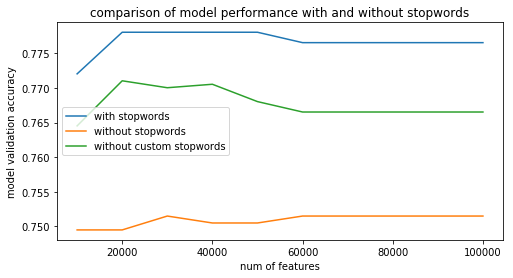

In [21]:
plt.figure(figsize=(8,4))
plt.plot(res_w_sw.n_features, res_w_sw.val_acc, label='with stopwords')
plt.plot(res_wo_sw.n_features, res_wo_sw.val_acc, label='without stopwords')
plt.plot(res_cust_sw.n_features, res_cust_sw.val_acc, label='without custom stopwords')
plt.title("comparison of model performance with and without stopwords")
plt.xlabel("num of features")
plt.ylabel("model validation accuracy")
plt.legend()

### Investigate gram length effect

In [22]:
res_bigram = compare_clf_nfeature(X_train, X_validation, y_train, y_validation, ngram_range=(1,2))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 6.30s
result on model with 20000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 6.01s
result on model with 30000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.00s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.03s
result on model with 50000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 5.99s
result on model with 60000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 5.95s
result on model with 70000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.00s
result on model with 80000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.04s
result on model with 90000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.

In [23]:
res_trigram = compare_clf_nfeature(X_train, X_validation, y_train, y_validation, ngram_range=(1,3))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.76
model auc : 0.76
train validation time : 11.98s
result on model with 20000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 12.03s
result on model with 30000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.97s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.77
train validation time : 11.95s
result on model with 50000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 11.80s
result on model with 60000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 11.93s
result on model with 70000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.83s
result on model with 80000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 12.19s
result on model with 90000 features
model accuracy : 0.78
model auc : 0.78
train validation t

In [24]:
res_bigram = pd.DataFrame(res_bigram, columns=cols)
res_trigram = pd.DataFrame(res_trigram, columns=cols)

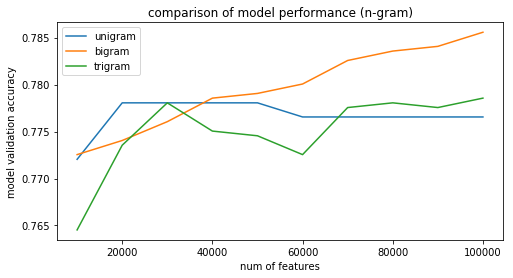

In [25]:
plt.figure(figsize=(8,4))
plt.plot(res_w_sw.n_features, res_w_sw.val_acc, label='unigram')
plt.plot(res_bigram.n_features, res_bigram.val_acc, label='bigram')
plt.plot(res_trigram.n_features, res_trigram.val_acc, label='trigram')
plt.title("comparison of model performance (n-gram)")
plt.xlabel("num of features")
plt.ylabel("model validation accuracy")
plt.legend()

### Lemmatize

In [26]:
from nltk.stem import WordNetLemmatizer

In [27]:
normalizer = WordNetLemmatizer()

In [28]:
df_train_data_2 = df_train_data.copy()
df_train_data_2['tweet'] = [' '.join([normalizer.lemmatize(word) for word in t.split()]) for t in df_train_data_2['tweet'].tolist()]
X_train, X_validation, y_train, y_validation = train_test_split(df_train_data.tweet, df_train_data.target, test_size = 0.02, random_state = 1234)

In [29]:
res_trigram_lemma = compare_clf_nfeature(X_train, X_validation, y_train, y_validation, ngram_range=(1,3))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.76
model auc : 0.76
train validation time : 11.72s
result on model with 20000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 11.75s
result on model with 30000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.88s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.77
train validation time : 12.30s
result on model with 50000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 12.08s
result on model with 60000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 11.74s
result on model with 70000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.83s
result on model with 80000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.82s
result on model with 90000 features
model accuracy : 0.78
model auc : 0.78
train validation t

### Stem

In [30]:
from nltk.stem import PorterStemmer

In [31]:
normalizer = PorterStemmer()

In [32]:
df_train_data_2 = df_train_data.copy()
df_train_data_2['tweet'] = [' '.join([normalizer.stem(word) for word in t.split()]) for t in df_train_data_2['tweet'].tolist()]
X_train, X_validation, y_train, y_validation = train_test_split(df_train_data.tweet, df_train_data.target, test_size = 0.02, random_state = 1234)

In [33]:
df_train_data_2.tail()

,tweet,target
548175,nice photo dude may ask for the origin to make...,1
445307,ok log out if all care probabl not but whatev ...,1
198986,grace dr appt get shot daddi will have to hold...,0
128709,have to go shop for black pant when get off of...,0
563079,gut could not get ticket for your show tonight...,1


In [34]:
res_trigram_stem = compare_clf_nfeature(X_train, X_validation, y_train, y_validation, ngram_range=(1,3))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.76
model auc : 0.76
train validation time : 11.62s
result on model with 20000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 11.71s
result on model with 30000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.62s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.77
train validation time : 11.67s
result on model with 50000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 11.88s
result on model with 60000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 11.78s
result on model with 70000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.83s
result on model with 80000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.77s
result on model with 90000 features
model accuracy : 0.78
model auc : 0.78
train validation t

In [35]:
res_trigram_lemma = pd.DataFrame(res_trigram_lemma, columns=cols)
res_trigram_stem = pd.DataFrame(res_trigram_stem, columns=cols)

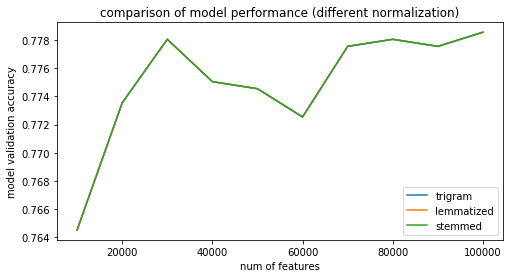

In [36]:
plt.figure(figsize=(8,4))
plt.plot(res_trigram.n_features, res_trigram.val_acc, label='trigram')
plt.plot(res_trigram_lemma.n_features, res_trigram_lemma.val_acc, label='lemmatized')
plt.plot(res_trigram_stem.n_features, res_trigram_stem.val_acc, label='stemmed')
plt.title("comparison of model performance (different normalization)")
plt.xlabel("num of features")
plt.ylabel("model validation accuracy")
plt.legend()

### TfIdf

In [37]:
X_train, X_validation, y_train, y_validation = train_test_split(df_train_data.tweet, df_train_data.target, test_size = 0.02, random_state = 1234)
tf_vectorizer = TfidfVectorizer()
res_tfidf_trigram = compare_clf_nfeature(X_train, X_validation, y_train, y_validation, ngram_range=(1,3), vectorizer=tf_vectorizer)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.76
model auc : 0.76
train validation time : 11.57s
result on model with 20000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.94s
result on model with 30000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.76s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.71s
result on model with 50000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.93s
result on model with 60000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.82s
result on model with 70000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.83s
result on model with 80000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 11.95s
result on model with 90000 features
model accuracy : 0.78
model auc : 0.78
train validation t

In [38]:
res_tfidf_bigram = compare_clf_nfeature(X_train, X_validation, y_train, y_validation, ngram_range=(1,2), vectorizer=tf_vectorizer)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 6.11s
result on model with 20000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 6.37s
result on model with 30000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 6.12s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.02s
result on model with 50000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 5.98s
result on model with 60000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.06s
result on model with 70000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.04s
result on model with 80000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.04s
result on model with 90000 features
model accuracy : 0.78
model auc : 0.78
train validation time : 6.

In [39]:
res_tfidf_unigram = compare_clf_nfeature(X_train, X_validation, y_train, y_validation, ngram_range=(1,1), vectorizer=tf_vectorizer)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
result on model with 10000 features
model accuracy : 0.76
model auc : 0.76
train validation time : 2.16s
result on model with 20000 features
model accuracy : 0.76
model auc : 0.76
train validation time : 2.16s
result on model with 30000 features
model accuracy : 0.77
model auc : 0.76
train validation time : 2.17s
result on model with 40000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.16s
result on model with 50000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.22s
result on model with 60000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.20s
result on model with 70000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.31s
result on model with 80000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.27s
result on model with 90000 features
model accuracy : 0.77
model auc : 0.77
train validation time : 2.

In [40]:
res_tfidf_unigram = pd.DataFrame(res_tfidf_unigram, columns=cols)
res_tfidf_bigram = pd.DataFrame(res_tfidf_bigram, columns=cols)
res_tfidf_trigram = pd.DataFrame(res_tfidf_trigram, columns=cols)

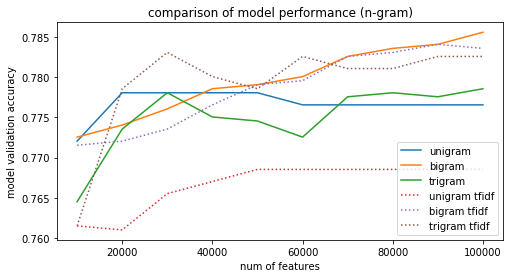

In [41]:
plt.figure(figsize=(8,4))
plt.plot(res_w_sw.n_features, res_w_sw.val_acc, label='unigram')
plt.plot(res_bigram.n_features, res_bigram.val_acc, label='bigram')
plt.plot(res_trigram.n_features, res_trigram.val_acc, label='trigram')
plt.plot(res_tfidf_unigram.n_features, res_tfidf_unigram.val_acc, label='unigram tfidf', linestyle=':')
plt.plot(res_tfidf_bigram.n_features, res_tfidf_bigram.val_acc, label='bigram tfidf', linestyle=':')
plt.plot(res_tfidf_trigram.n_features, res_tfidf_trigram.val_acc, label='trigram tfidf', linestyle=':')
plt.title("comparison of model performance (n-gram)")
plt.xlabel("num of features")
plt.ylabel("model validation accuracy")
plt.legend()

### Final NB Model

In [42]:
def plot_cm(cm):
    labels = ['negative', 'positive']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the sentiment analysis')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

#### Count

In [43]:
X_train, y_train = df_train_data.tweet, df_train_data.target
X_test, y_test = df_test_data.tweet, df_test_data.target

In [44]:
clf = MultinomialNB()
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=90000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [45]:
clf.fit(X_train, y_train)
probas = clf.predict_proba(X_test)
y_pred = np.argmax(probas, axis=-1)
y_pred_prob = [i[1] for i in probas]
acc_score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(acc_score)
print(cm)

0.782328
[[395470 104530]
 [113142 386858]]


              precision    recall  f1-score   support

           0     0.7775    0.7909    0.7842    500000
           1     0.7873    0.7737    0.7804    500000

    accuracy                         0.7823   1000000
   macro avg     0.7824    0.7823    0.7823   1000000
weighted avg     0.7824    0.7823    0.7823   1000000



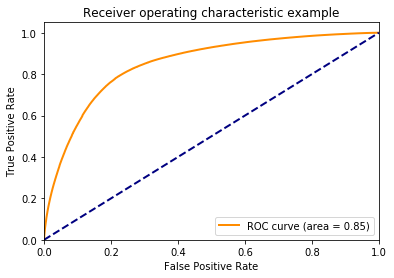

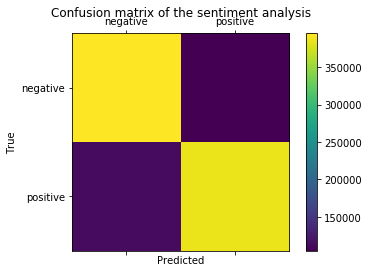

In [46]:
print(classification_report(y_test, y_pred, digits=4))
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

plot_cm(cm)

#### TF-Idf

0.783869
[[401514  98486]
 [117645 382355]]
              precision    recall  f1-score   support

           0     0.7734    0.8030    0.7879    500000
           1     0.7952    0.7647    0.7796    500000

    accuracy                         0.7839   1000000
   macro avg     0.7843    0.7839    0.7838   1000000
weighted avg     0.7843    0.7839    0.7838   1000000



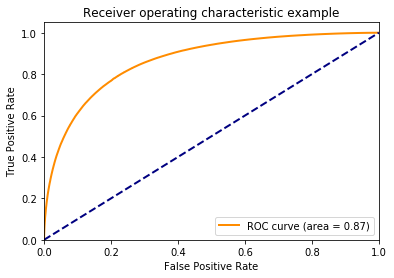

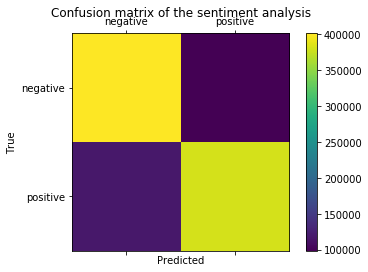

In [47]:
X_train, y_train = df_train_data.tweet, df_train_data.target
X_test, y_test = df_test_data.tweet, df_test_data.target
clf = MultinomialNB()
tf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=90000)
X_train = tf_vectorizer.fit_transform(X_train)
X_test = tf_vectorizer.transform(X_test)

clf.fit(X_train, y_train)
probas = clf.predict_proba(X_test)
y_pred = np.argmax(probas, axis=-1)
y_pred_prob = [i[1] for i in probas]

acc_score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(acc_score)
print(cm)

print(classification_report(y_test, y_pred, digits=4))
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

plot_cm(cm)

### Final Model SVM

In [48]:
def plot_auc(label, prediction):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(label, prediction, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

def find_params(x_train, y_train):
    C_range = np.logspace(-3, 10, 8)
    param_grid = dict(C=C_range)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(LinearSVC(), param_grid=param_grid, cv=cv)
    grid.fit(x_train, y_train)
    
    # Draw plot for gamma-C value result
    score_dict = grid.grid_scores_

    scores = [x[1] for x in score_dict]
    scores = np.array(scores).reshape(len(C_range))
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.get_cmap("Spectral"))
    plt.ylabel('C')
    plt.colorbar()
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.show()
    
    return grid.best_params_

In [50]:
from sklearn.calibration import CalibratedClassifierCV

def sentiment_svm(train, test, C, frac = 1, max_features = None, kernel='linear', ngram_range=(1,3), gamma=0, use_params=False):
    X_train, y_train = train.sample(frac=frac, random_state=1234).tweet, train.sample(frac=frac, random_state=1234).target
    X_test, y_test = test.sample(frac=frac, random_state=1234).tweet, test.sample(frac=frac, random_state=1234).target

    tf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train = tf_vectorizer.fit_transform(X_train)
    X_test = tf_vectorizer.transform(X_test)

    #svd = TruncatedSVD(n_components=10)
    #X_train = svd.fit_transform(X_train)
    #X_test = svd.transform(X_test)
    
    if kernel == 'linear':
        if use_params:
            params = find_params(X_train, y_train)
            print ('Best params: %s' % (params))
#             svm = LinearSVC(C=params['C'])
            svm = CalibratedClassifierCV(base_estimator=LinearSVC(C=params['C']), cv=5)
        else:
#             svm = LinearSVC(C=C)
            svm = CalibratedClassifierCV(base_estimator=LinearSVC(C=C), cv=5)
    else:
#         svm = SVC(C=C, gamma=gamma)
        svm = CalibratedClassifierCV(base_estimator=SVC(C=C, gamma=gamma), cv=5)
        
    print(svm)    
    
    t0 = time()
    svm.fit(X_train, y_train)
    train_test_time = time() - t0
    print("training time: {0:.2f}s".format(train_test_time))
    
    probas = svm.predict_proba(X_test)
    y_pred = np.argmax(probas, axis=-1)
    y_pred_prob = [i[1] for i in probas]

    acc_score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print("Model accuracy = {0:.3f}%".format(acc_score*100))
    print(classification_report(y_test, y_pred, digits=4))

    plot_auc(y_test, y_pred_prob)
    plot_cm(cm)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
training time: 5.30s
Model accuracy = 79.868%
              precision    recall  f1-score   support

           0     0.7806    0.8309    0.8050    500000
           1     0.8192    0.7665    0.7920    500000

    accuracy                         0.7987   1000000
   macro avg     0.7999    0.7987    0.7985   1000000
weighted avg     0.7999    0.7987    0.7985   1000000



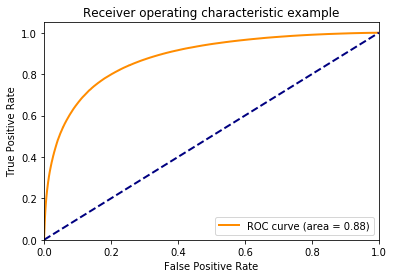

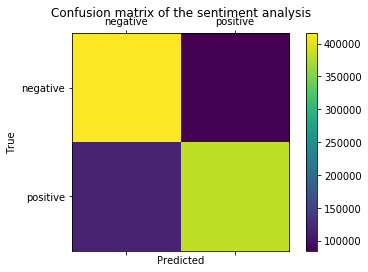

In [51]:
sentiment_svm(df_train_data, df_test_data, 0.5)

CalibratedClassifierCV(base_estimator=SVC(C=10, cache_size=200,
                                          class_weight=None, coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma=0.1, kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=5, method='sigmoid')
training time: 19.00s
Model accuracy = 73.800%
              precision    recall  f1-score   support

           0     0.7191    0.7856    0.7509     25129
           1     0.7610    0.6899    0.7237     24871

    accuracy                         0.7380     50000
   macro avg     0.7401    0.7378    0.7373     50000
weighted avg     0.7399    0.7380    0.7374     50000



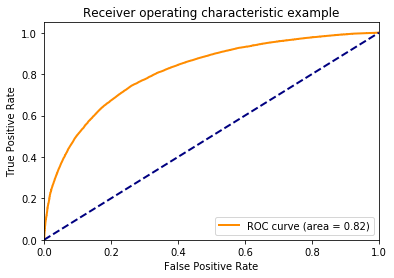

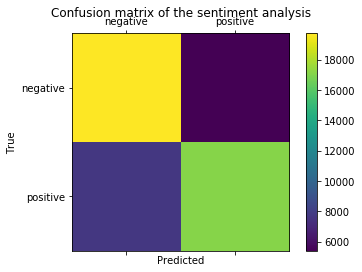

In [52]:
sentiment_svm(df_train_data, df_test_data, C=10, frac=0.05, kernel='rbf', gamma=0.1)

CalibratedClassifierCV(base_estimator=SVC(C=10, cache_size=200,
                                          class_weight=None, coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma=0.1, kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=5, method='sigmoid')
training time: 118.09s
Model accuracy = 75.509%
              precision    recall  f1-score   support

           0     0.7322    0.8048    0.7668     50036
           1     0.7830    0.7053    0.7421     49964

    accuracy                         0.7551    100000
   macro avg     0.7576    0.7551    0.7545    100000
weighted avg     0.7576    0.7551    0.7545    100000



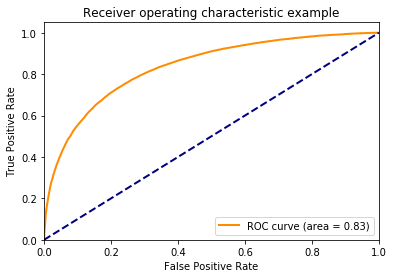

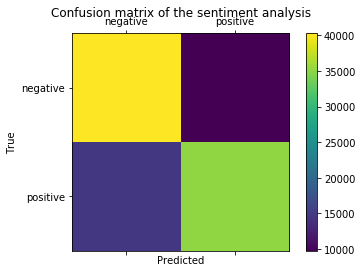

In [53]:
sentiment_svm(df_train_data, df_test_data, C=10, frac=0.1, kernel='rbf', gamma=0.1)

### Neural Net Model

In [57]:
from keras.layers import *
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle

Using TensorFlow backend.


In [58]:
X_train = list(df_train_data.tweet)
X_test = list(df_test_data.tweet)

In [59]:
y_train = [[1,0] if x == 0 else [0,1] for x in df_train_data.target]
y_test = [[1,0] if x == 0 else [0,1] for x in df_test_data.target]

In [60]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [61]:
max_feature = 5000
maxlen = 50
embed_size = 25

In [62]:
tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(X_train)

In [63]:
token_train = tokenizer.texts_to_sequences(X_train)
token_test = tokenizer.texts_to_sequences(X_test)

In [64]:
X_train_final = pad_sequences(token_train, maxlen=maxlen, padding='post')
X_test_final = pad_sequences(token_test, maxlen=maxlen, padding='post')

In [65]:
from IPython.display import clear_output
import keras

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [66]:
from keras import optimizers
from keras import regularizers
eta = 1

input = Input(shape=(maxlen,))
net = Embedding(max_feature, embed_size)(input)
net = Dropout(0.2)(net)
net = BatchNormalization()(net)

net = Conv1D(16, 8, padding='same', activation='relu')(net)
net = Dropout(0.2)(net)
net = BatchNormalization()(net)
net = Conv1D(16, 4, padding='same', activation='relu')(net)
net = Dropout(0.2)(net)
net = BatchNormalization()(net)
net = Conv1D(16, 4, padding='same', activation='relu')(net)
net = Dropout(0.2)(net)
net = BatchNormalization()(net)
net = Conv1D(16, 4, padding='same', activation='relu')(net)
net = Dropout(0.2)(net)
net1 = BatchNormalization()(net)

net = Conv1D(2, 1)(net)
net = GlobalAveragePooling1D()(net)
output = Activation('softmax')(net)
model = Model(inputs = input, outputs = output)
ada = optimizers.Adadelta(lr=eta, rho=0.95, epsilon=None, decay=0.0)
model.compile(optimizer=ada, loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 25)            125000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 25)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 25)            100       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 16)            3216      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 16)            64  

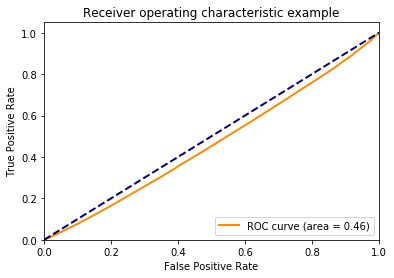

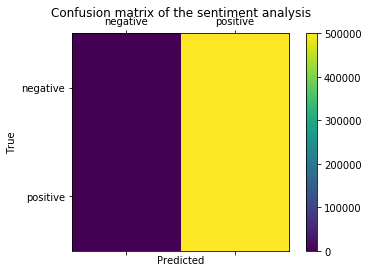

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    500000
           1     0.5000    1.0000    0.6667    500000

    accuracy                         0.5000   1000000
   macro avg     0.2500    0.5000    0.3333   1000000
weighted avg     0.2500    0.5000    0.3333   1000000



In [69]:
y_prob = model.predict(X_test_final)
y_pred = y_prob.argmax(axis=-1)
y_test_raw = [0 if (x == [1,0]).all() else 1 for x in y_test]
y_pred_prob = [i[1] for i in y_prob]
plot_auc(y_test_raw, y_pred_prob)
plot_cm(confusion_matrix(y_test_raw, y_pred))
print(classification_report(y_test_raw, y_pred, digits=4))

In [70]:
from keras.utils import to_categorical
from keras.models import Sequential

def lstm_rnn_classifier(train_df, test_df, vectorizer):
    if vectorizer == 'cv':
        vctr = CountVectorizer()
    elif vectorizer == 'ngram':
        vctr = CountVectorizer()
    elif vectorizer == 'tfidf':
        vctr = TfidfVectorizer()
        
    X_train, y_train = vctr.fit_transform(train_df['tweet']), train_df['target']
    X_test, y_test = vctr.transform(test_df['tweet']), test_df['target']
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    embed_dim = 128
    lstm_out = 196
    max_features = 2000
    
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length = X_train.shape[1]))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    print(model.summary())
        
    batch_size = 32
    epochs = 7
    model.fit(X_train, y_train, epochs = epochs, batch_size=batch_size, verbose = 2)
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_pred, y_test)
    plot_auc(y_test, y_pred)
    
    return y_pred, cm, model, accuracy, y_test

In [ ]:
lstm_rnn_classifier(df_train_data, df_test_data, 'tfidf')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 52872, 128)        256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 52872, 128)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7
